In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import scanpy as sc
import squidpy as sq
import numpy as np
import anndata as ad
import pandas as pd
import scvi
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
sample_list = ['HC01', 'HC02', 'HC03', 'HC05',
               'SSc4994', 'SSc5380', 
               'SSc-HL01', 'SSc-HL05', 'SSc-HL06', 'SSc-HL11',
               'SSc-HL13', 'SSc-HL25', 'SSc-HL33', 'SSc-HL35']

In [3]:
adata_list = list()

In [4]:
for sample in sample_list:
    adata = sc.read_h5ad(f'../../results/spatial/filtered_data/{sample}.h5ad')

    adata.obs['patient_id'] = sample
    
    if sample in ['HC01', 'HC02', 'HC03', 'HC05']:
        adata.obs['condition'] = 'Healthy'
    else:
        adata.obs['condition'] = 'SSc'
    
    adata_list.append(adata)

In [5]:
adata = ad.concat(adata_list)

In [6]:
adata

AnnData object with n_obs × n_vars = 13204 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'patient_id', 'condition'
    obsm: 'spatial'

In [7]:
# find mitochondria-encoded (MT) genes
adata.var['MT_gene'] = [gene.startswith('MT-') for gene in adata.var_names]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata.obsm['MT'] = adata[:, adata.var['MT_gene'].values].X.toarray()
adata = adata[:, ~adata.var['MT_gene'].values]

In [8]:
adata.obs_names_make_unique()

In [9]:
adata.layers['counts'] = adata.X.copy()

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

In [11]:
sc.tl.pca(adata)

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

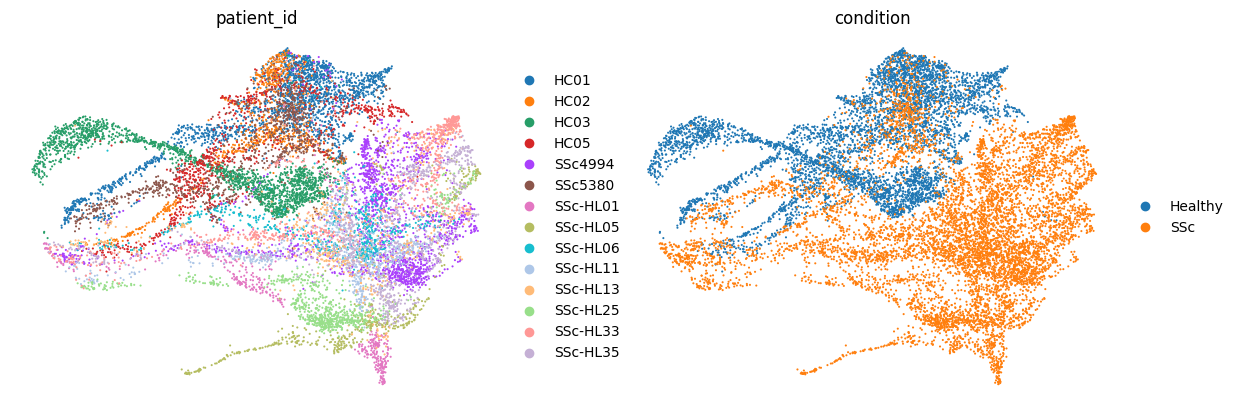

In [13]:
sc.pl.umap(adata, color=['patient_id', 'condition'], frameon=False)

In [14]:
# batch correction
from scipy.cluster.vq import kmeans2
import harmonypy as hm
import numpy as np

def cluster_fn(data, K):
    centroid, label = kmeans2(data, K, minit='++')
    return centroid

X = adata.obsm['X_pca'].astype(np.float64)

harmony_out = hm.run_harmony(X, adata.obs,
                             ['patient_id'], cluster_fn=cluster_fn)

adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

2024-09-06 01:29:15,695 - harmonypy - INFO - Iteration 1 of 10
2024-09-06 01:29:21,739 - harmonypy - INFO - Iteration 2 of 10
2024-09-06 01:29:27,911 - harmonypy - INFO - Iteration 3 of 10
2024-09-06 01:29:34,315 - harmonypy - INFO - Converged after 3 iterations


In [15]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

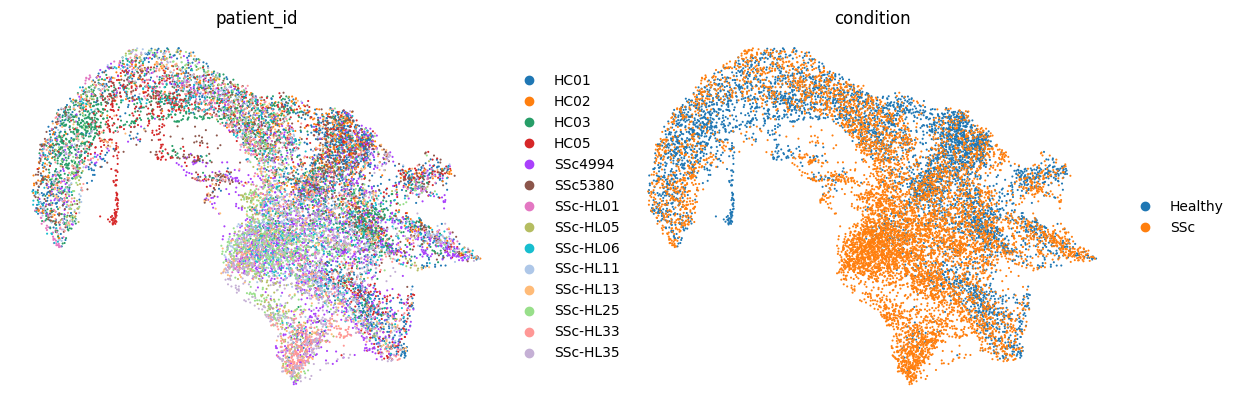

In [16]:
sc.pl.umap(adata, color=['patient_id', 'condition'], frameon=False)

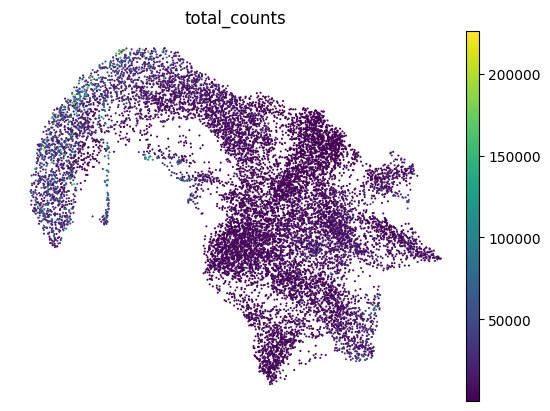

In [17]:
sc.pl.umap(adata, color=['total_counts'], frameon=False)

In [18]:
sc.tl.leiden(adata, resolution=0.3)

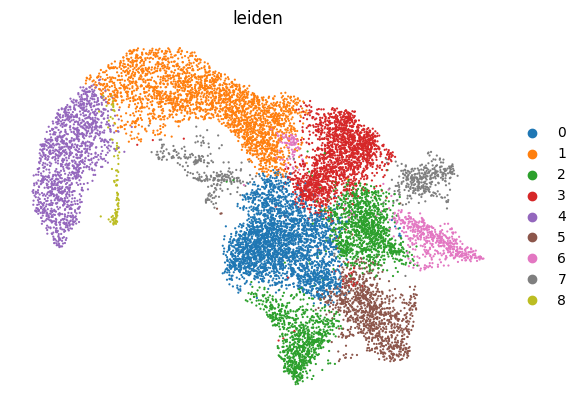

In [19]:
sc.pl.umap(adata, color=['leiden'], frameon=False, size=10)

In [3]:
# we can compute the cell-type composition between control and SSc
df_prop = pd.crosstab(adata.obs['patient_id'],adata.obs['leiden'], normalize='index').reset_index()
df_obs = adata.obs[['patient_id', 'condition']].drop_duplicates()
df_prop = pd.melt(df_prop, id_vars=['patient_id'], value_name='proportion')
df = df_prop.merge(df_obs)

df.to_csv(f'../../results/04_spatial/22_molecular_niches/niche_proportion.csv', index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8_Healthy vs. 8_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:4.863e-01 U_stat=2.350e+01
1_Healthy vs. 1_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:5.395e-02 U_stat=3.400e+01
0_Healthy vs. 0_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.399e-02 U_stat=3.000e+00
2_Healthy vs. 2_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:7.592e-02 U_stat=7.000e+00
3_Healthy vs. 3_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:5.395e-02 U_stat=3.400e+01
4_Healthy vs. 4_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:7.592e-02 U_stat=3.300e+01
5_Healthy vs. 5_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:7.333e-01 U_stat=2.300e+01
6_Healthy vs. 6_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+01
7_Healthy vs. 7_SSc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.878e-

(<Axes: xlabel='leiden', ylabel='proportion'>,
  <statannotations.Annotation.Annotation at 0x7fb9a28d5330>])

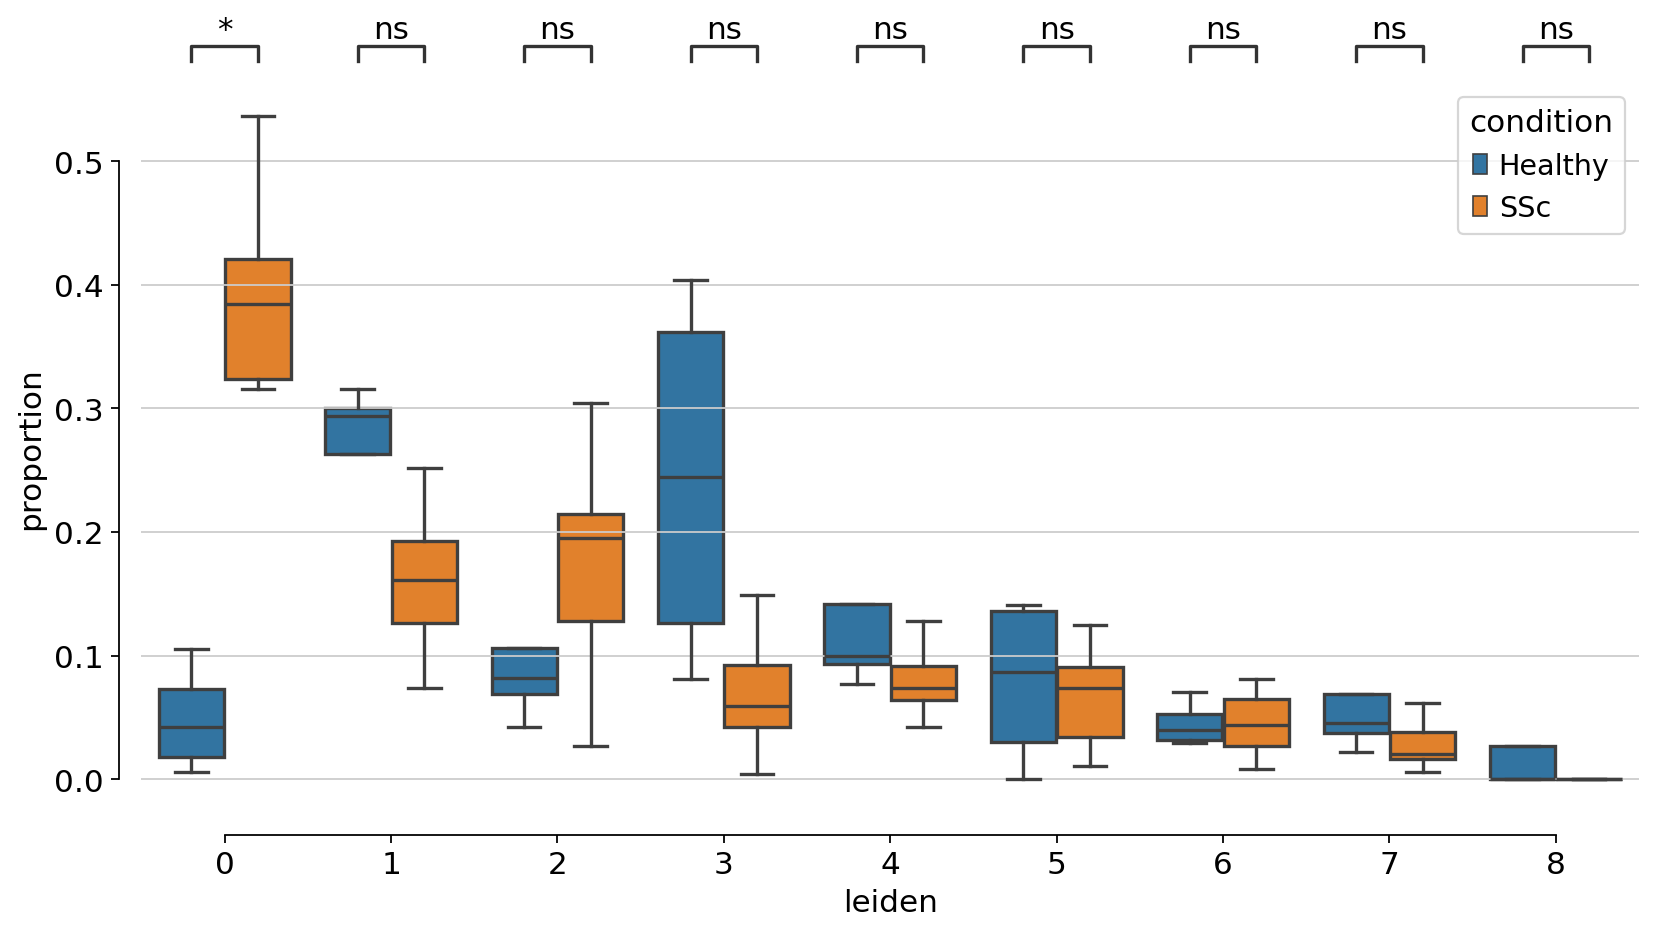

In [4]:
# visualize cell type proportion
sc.set_figure_params(figsize=(12, 6))
ax = sns.boxplot(data=df, 
                 x='leiden', y='proportion', 
                 hue="condition", 
                 showfliers = False)
sns.despine(offset=10, trim=True, ax=ax)

pairs=[(('0', "Healthy"), ('0', "SSc")),
      (('1', "Healthy"), ('1', "SSc")),
      (('2', "Healthy"), ('2', "SSc")),
      (('3', "Healthy"), ('3', "SSc")),
      (('4', "Healthy"), ('4', "SSc")),
      (('5', "Healthy"), ('5', "SSc")),
      (('6', "Healthy"), ('6', "SSc")),
      (('7', "Healthy"), ('7', "SSc")),
       (('8', "Healthy"), ('8', "SSc"))]

annotator = Annotator(ax, pairs, data=df, x='leiden', y='proportion', hue='condition')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [22]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
result = adata.uns['rank_genes_groups']

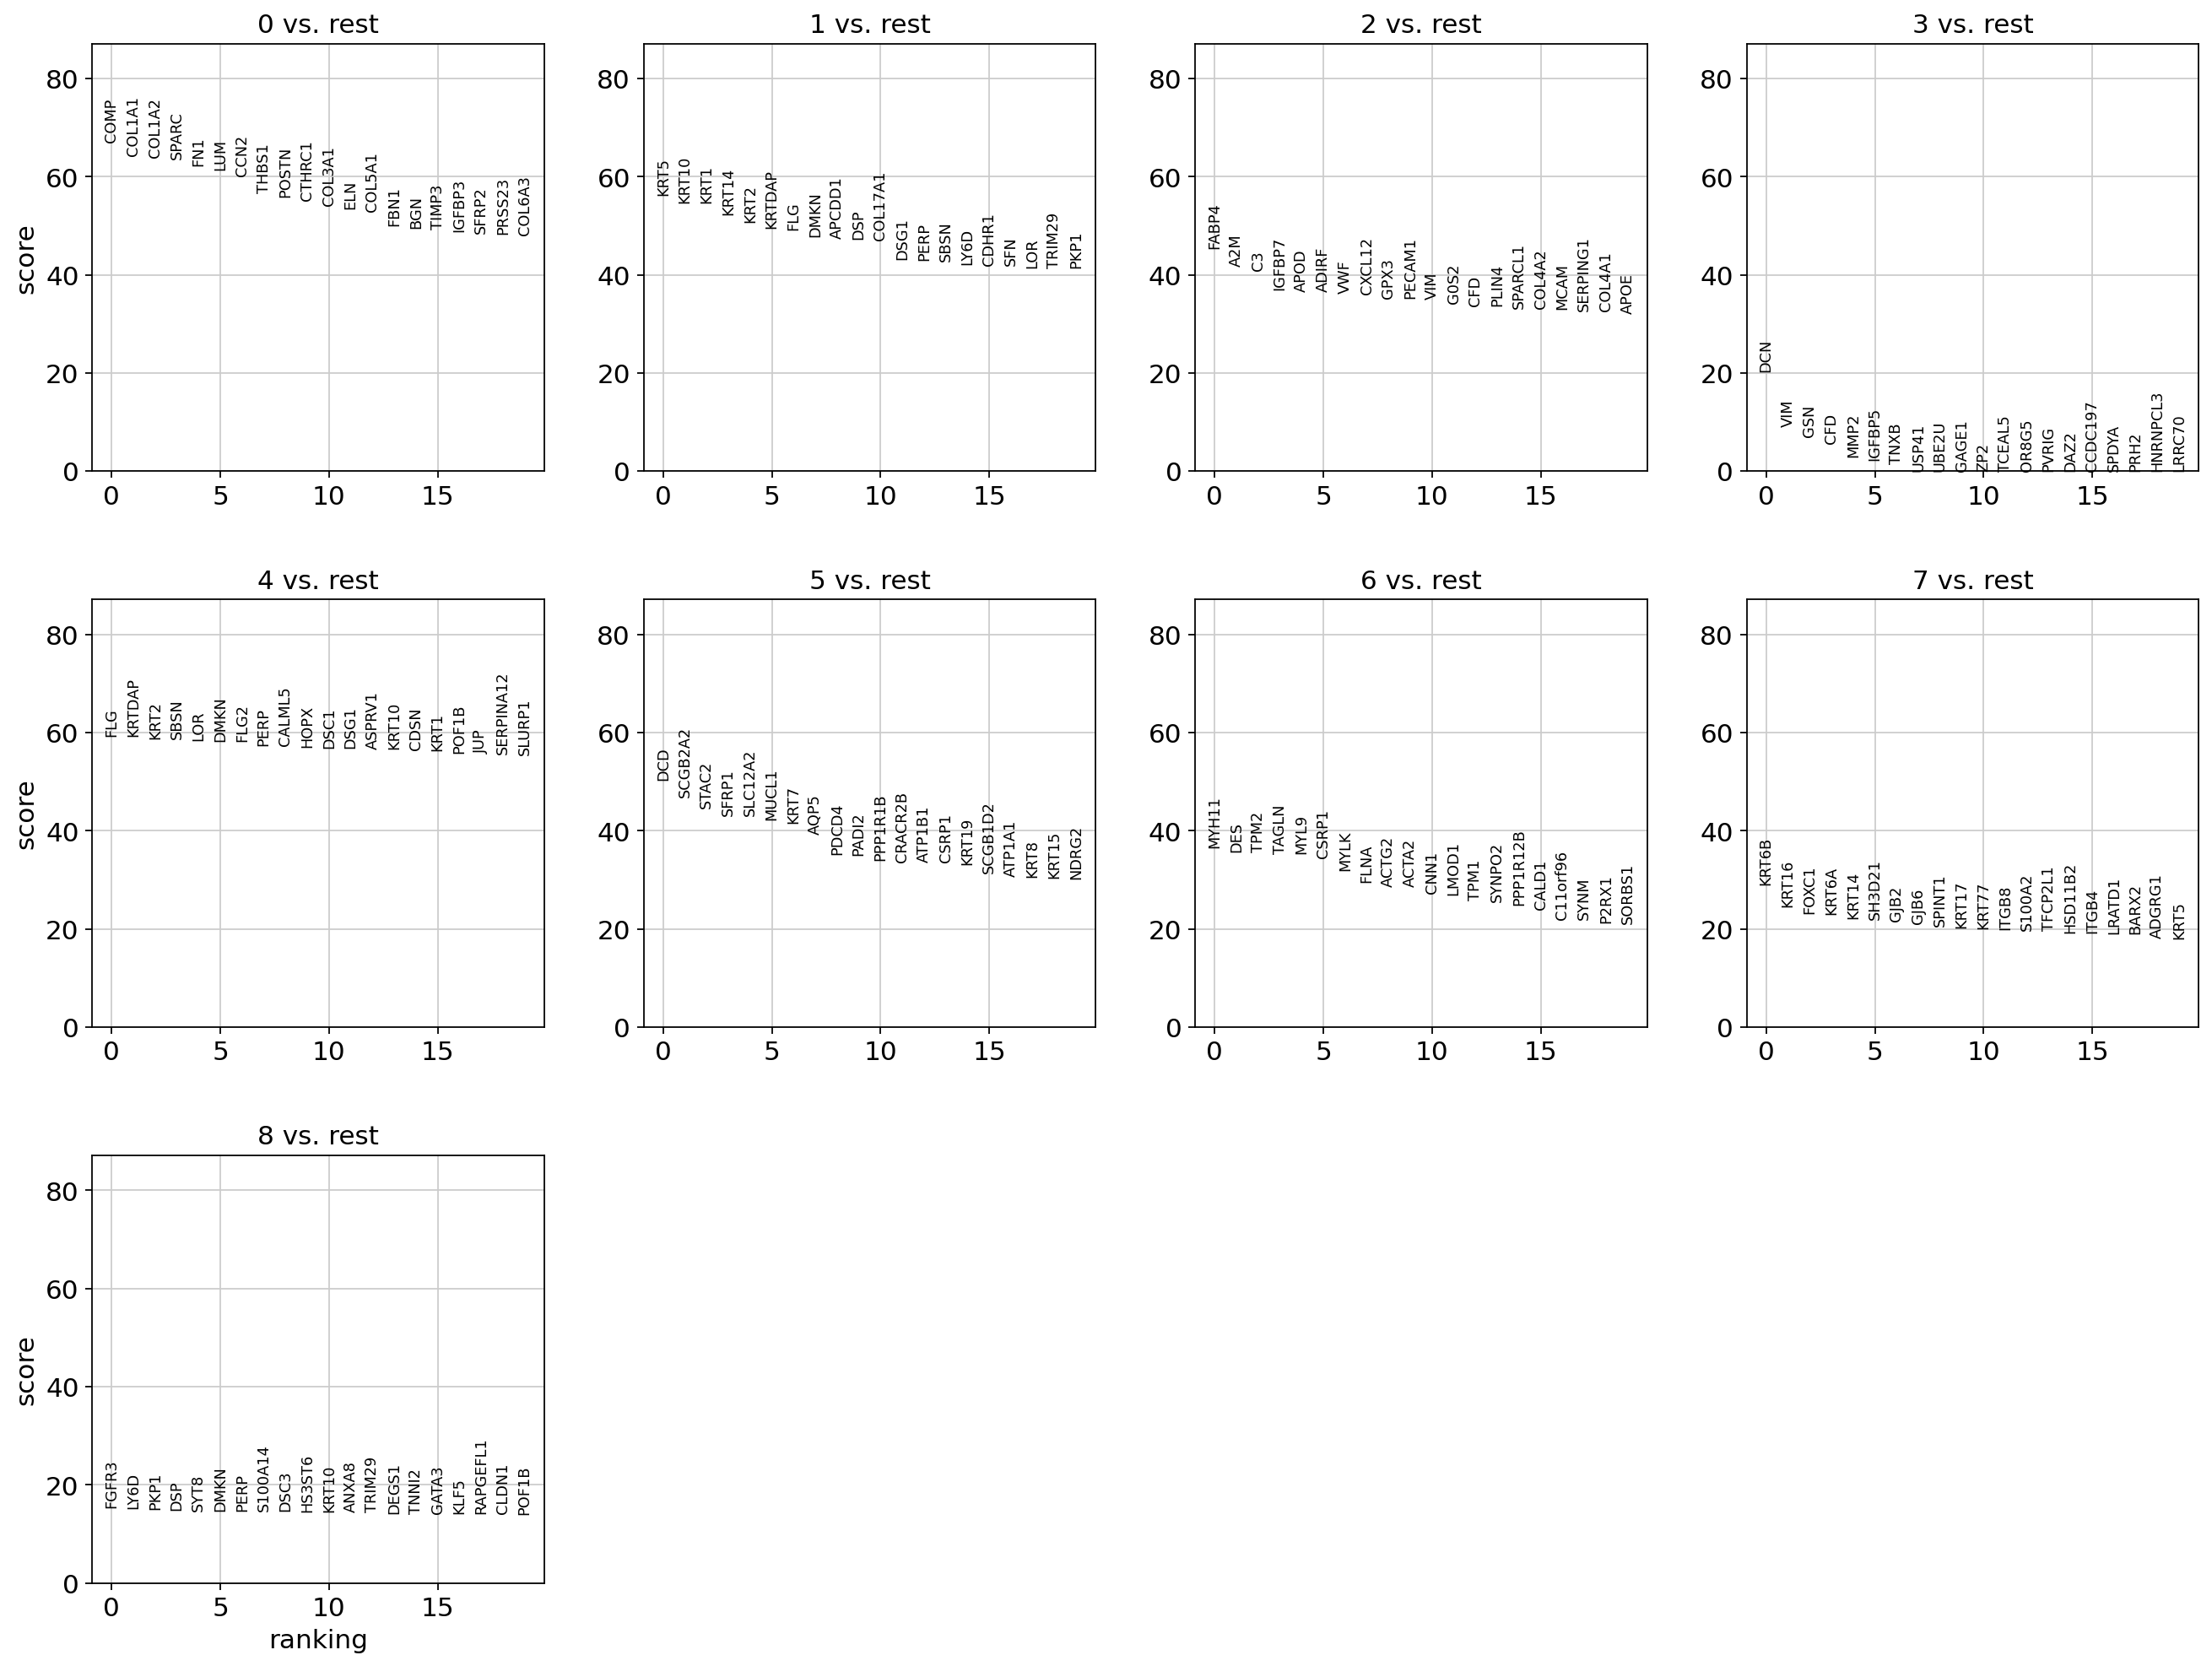

In [23]:
sc.set_figure_params(figsize=(5, 5))
sc.pl.rank_genes_groups(adata)

In [24]:
sc.tl.dendrogram(adata, groupby='leiden', use_rep='X_pca')

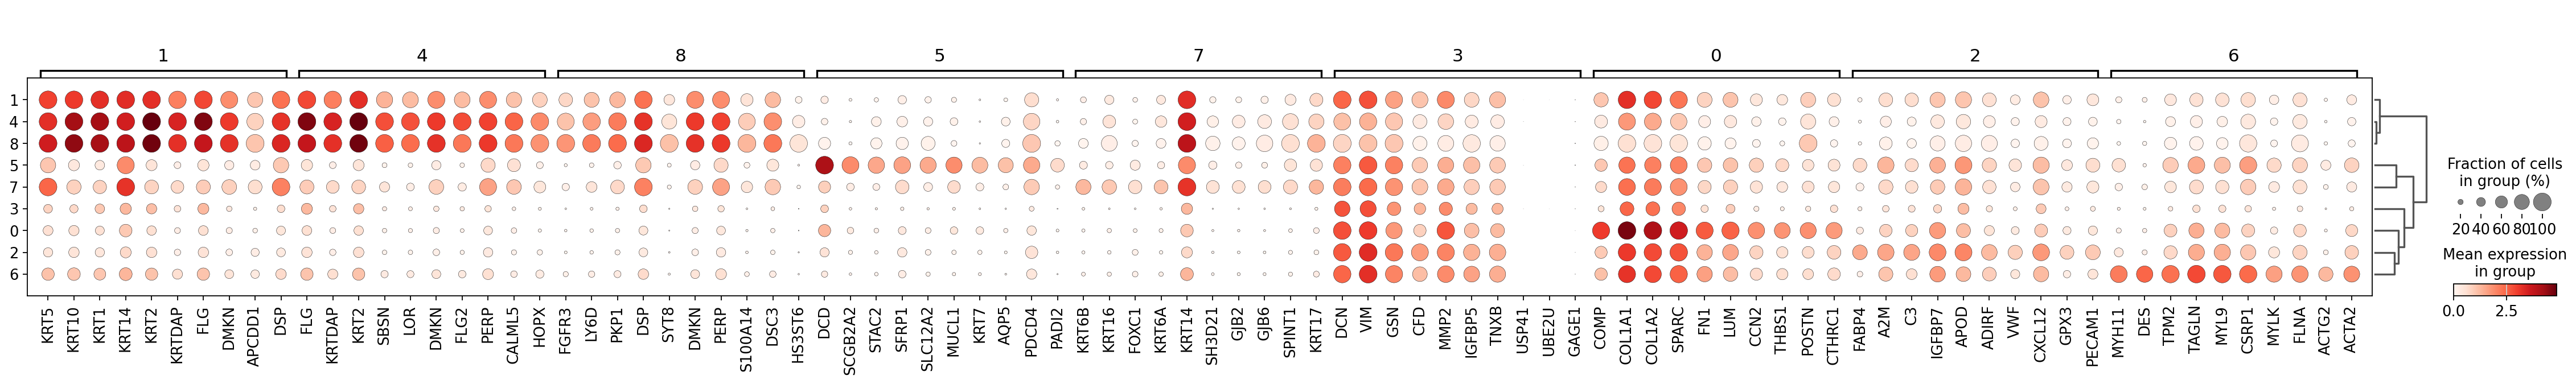

In [28]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, use_raw=False)

In [26]:
df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)
df.to_csv(f'../../results/04_spatial/22_molecular_niches/top_200.csv', index=False)

In [27]:
adata.write_h5ad('../../results/04_spatial/22_molecular_niches/integrated.h5ad')

In [2]:
adata = sc.read_h5ad('../../results/04_spatial/22_molecular_niches/integrated.h5ad')